# Surrogate Ensemble Modeling for Dynamic Climate Impact Models

### Import libraries

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from models.BLSTM import train_blstm
from models.BLSTM import calc_quantiles
from models.RFQR import train_rfqr
from utils.plotting import *
from utils.evaluate import *

/Users/juliankuehnert/.pyenv/versions/3.8.6/envs/ungana/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/juliankuehnert/.pyenv/versions/3.8.6/envs/ungana/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load dataset

The file `forecasts_R0-malaria-model-variables.csv` contain rainfall and temperature forecast ensembles and modeled malaria transmission coefficients.

In [2]:
dataset = 'forecasts_R0-malaria-model-variables.csv'

In [3]:
df = pd.read_csv('datasets/'+dataset)
df.datetime = pd.to_datetime(df.datetime)
df.head()

,forecast,precip,temp,datetime,year,month,day_of_month,day_of_year,season,P,gono_len,sporo_len,mosquitoes,R0
0,1,0.576628,17.865900,2017-01-01,2017,1,1,1,Spring,0.904054,5.173293,1000.000000,0.0,0.0
1,1,0.166432,18.287195,2018-01-01,2018,1,1,1,Spring,0.902434,4.983980,386.497216,0.0,0.0
2,1,1.760069,19.013910,2019-01-01,2019,1,1,1,Spring,0.898305,4.694860,109.477182,0.0,0.0
3,1,0.000000,16.801691,2020-01-01,2020,1,1,1,Spring,0.905616,5.742562,1000.000000,0.0,0.0
4,1,0.950271,17.495355,2021-01-01,2021,1,1,1,Spring,0.905009,5.355321,1000.000000,0.0,0.0


## Prepare training and testing datasets

In [23]:
split = "split-by-year"
train_ensembles = 0.7

train_years = [2017, 2018, 2019, 2020]
test_years = [2021]

features = ['day_of_month', 'month', 'precip', 'temp']#,'R0']
target   = ['R0']

quantiles = [0.1587, 0.50, 0.8413]
labels = ['R0 lower', 'R0 mean', 'R0 upper']

In [24]:
def scale_data(data, train_years, test_years, features, target):
    
    df_train = data[data['year'].isin(train_years)].copy()
    
    # Fit Scaler only on Training features
    feature_scaler = StandardScaler()
    feature_scaler.fit(df_train[features].values)
    # Fit Scaler only on Training target values
    if target in features:
        target_scaler = StandardScaler()
        target_scaler.fit(df_train[target].values)
    else: 
        target_scaler = None

    # Transfom on both Training and Test data
    data_values = data[features].values.copy()
    data = data.drop(columns=(features))
    data = data.join(pd.DataFrame(feature_scaler.transform(data_values),
                                  columns=features))
    return data, feature_scaler, target_scaler

def select_sliding_data(data, features, target, sequence_length):
    X_list, y_list = [], []
    idxs_selection = pd.Index([])
    for iyear in data['year'].unique():
        data_yearly = data[data['year']==iyear].copy()
        for iseason in data_yearly['season'].unique():
            data_seasonal = data_yearly[data_yearly['season']==iseason].copy()
            for iforecast in data_seasonal['forecast'].unique():
                idata_X = data_seasonal[data_seasonal['forecast']==iforecast][features].values
                idata_y = data_seasonal[data_seasonal['forecast']==iforecast][target].values
                for ii in range(len(idata_X)):
                    if (ii+sequence_length-1) < len(idata_X):              ### if -1: predict for last timestamp in sequence
                        X_list.append(idata_X[ii:ii+sequence_length, :])
                        y_list.append(idata_y[ii+sequence_length-1])       ### if -1: predict for last timestamp in sequence
                idxs_selection = idxs_selection.union(data_seasonal[data_seasonal['forecast']==iforecast].iloc[sequence_length-1:].index, sort=False)
    return(np.array(X_list), np.squeeze(np.array(y_list)), idxs_selection)

In [25]:
df_scaled, feature_scaler, target_scaler = scale_data(df.copy(), train_years, test_years, features, target)

sequence_length = 50

df_train_scaled = df_scaled[df_scaled['year'].isin(train_years)].copy()
df_test_scaled = df_scaled[df_scaled['year'].isin(test_years)].copy()

X_train, y_train, idxs_train = select_sliding_data(df_train_scaled, features, target, sequence_length)
X_test, y_test, idxs_test = select_sliding_data(df_test_scaled, features, target, sequence_length)

df_test = df[['datetime', 'forecast', 'season', 'R0']].iloc[idxs_test].copy()

## BLSTM

In [29]:
## Model parameters
n_features = len(features)
output_length = 1
batch_size = 4096
n_epochs = 200
learning_rate = 0.01
n_experiments = 200
load_model = None #'BLSTM_train2017-2020_predict2021_e200_t0-01_seq50_feat5_bs4096.pth'

In [30]:
## Model training and prediciton with MC dropout
y_pred_blstm_samples = train_blstm(X_train, y_train, X_test, n_features, output_length, batch_size, n_epochs, learning_rate, sequence_length, n_experiments, target_scaler, split, save_model=True)

Monte Carlo Dropout ... Experiments:   0%|          | 0/200 [00:00<?, ?it/s]

Total time elapsed: 76542.36028528214
Average time per epoch: 382.71180142641066


Monte Carlo Dropout ... Experiments: 100%|██████████| 200/200 [31:31<00:00,  9.46s/it]


In [32]:
## Merge with true values and save dataframe
df_test_blstm_samples = pd.concat([df_test.reset_index(), y_pred_blstm_samples], axis=1) 
df_test_blstm_samples.to_csv('trained_models/blstm'
                     +'_'+split
                     +'_seq'+str(sequence_length)
                     +'_feat'+str(n_features)
                     +'_bs'+str(batch_size)
                     +'_eps'+str(n_epochs)
                     +'_lr'+str(learning_rate)
                     +'_samples.csv', index=False)

In [33]:
## Compute quantiles from samples
y_pred_blstm = calc_quantiles(y_pred_blstm_samples, quantiles, labels)

Calculating R0 lower quantile: 0.1587
Calculating R0 mean quantile: 0.5
Calculating R0 upper quantile: 0.8413


In [34]:
## Merge with true values and save dataframe
df_test_blstm = pd.concat([df_test.reset_index(), y_pred_blstm], axis=1) 
df_test_blstm.to_csv('trained_models/blstm'
                     +'_'+split
                     +'_seq'+str(sequence_length)
                     +'_feat'+str(n_features)
                     +'_bs'+str(batch_size)
                     +'_eps'+str(n_epochs)
                     +'_lr'+str(learning_rate)
                     +'.csv', index=False)

## RFQR

In [45]:
## Model parameters
random_state=0
min_samples_split=10
n_estimators=1000
n_jobs=8
verbose=True
load_model_rfqr = None #'RFQR_train2017-2020_predict2021_feat4_excludeR0_predict50th.joblib'

In [46]:
## Model training and prediciton of quantiles
y_pred_rfqr = train_rfqr(X_train, y_train, X_test, random_state, min_samples_split, n_estimators, n_jobs, target_scaler, split, sequence_length, n_features, verbose=True, save_model=True, load_model=load_model_rfqr)

Training model ...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   28.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  6.3min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 11.3min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed: 14.5min finished


Predicting quantile: R0 lower


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.8s finished


Predicting quantile: R0 mean


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.7s finished


Predicting quantile: R0 upper


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished


In [48]:
## Merge with true values and save dataframe
df_test_rfqr = pd.concat([df_test.reset_index(), y_pred_rfqr], axis=1) 
df_test_rfqr.to_csv('trained_models/rfqr'
                    +'_'+split
                    +'_seq'+str(sequence_length)
                    +'_feat'+str(n_features)
                    +'_rs'+str(random_state)
                    +'_minss'+str(min_samples_split)
                    +'_estims'+str(n_estimators)
                    +'_jobs'+str(n_jobs)
                    +'.csv', index=False)

# Result evaluation

In [6]:
# Load results
df_test_blstm = pd.read_csv('trained_models/blstm_split-by-year_seq50_feat4_bs4096_eps200_lr0.01.csv')
df_test_rfqr = pd.read_csv('trained_models/rfqr_split-by-year_seq50_feat4_rs0_minss10_estims1000_jobs8.csv')

### 1) Evaluate predictive performance on single ensemble members

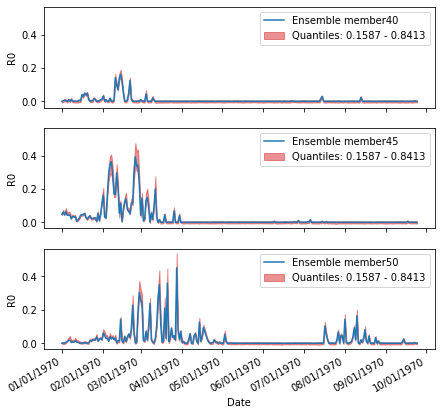

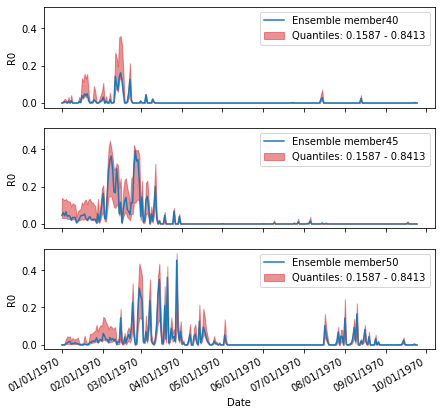

In [14]:
# Plot time series of individual ensemble members
iforecasts = [40, 45, 50]
fig = plot_single_members(df_test_blstm, iforecasts, 'figures/blstm_2017-2021_iforecast.pdf')
fig = plot_single_members(df_test_rfqr, iforecasts, 'figures/rfqr_2017-2021_iforecast.pdf')

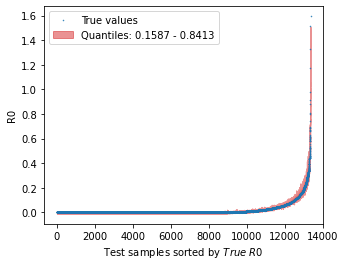

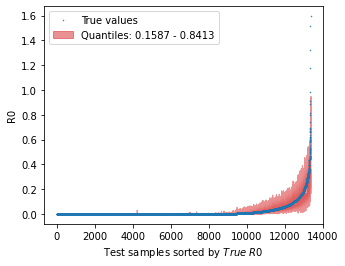

In [15]:
# Plot all predicted quantile ranges together with all true R0 values, sorted by the latter
plot_true_in_interval(df_test_blstm, 'R0', 'figures/blstm_2017-2021_interval.pdf');
plot_true_in_interval(df_test_rfqr, 'R0', 'figures/rfqr_2017-2021_interval.pdf');

In [201]:
# Calculate RMSE between true R0 and predicted median R0
print('BLSTM: RMSE between true R0 and predicted median R0 = ', calc_rmse(df_test_blstm, 'R0', 'R0 mean'))
print('RFQR: RMSE between true R0 and predicted median R0 = ',  calc_rmse(df_test_rfqr, 'R0', 'R0 mean'))

BLSTM: RMSE between true R0 and predicted median R0 =  0.008019470998423362
RFQR: RMSE between true R0 and predicted median R0 =  0.025495104333954598


In [8]:
# Calculate ranges of confidence between predicted median R0 and lower/upper quantile
print('BLSTM: Lower confidence = ', (df_test_blstm['R0 lower']-df_test_blstm['R0 mean']).mean())
print('BLSTM: Upper confidence = ', (df_test_blstm['R0 upper']-df_test_blstm['R0 mean']).mean())
print('BLSTM: Lower confidence = ', (df_test_rfqr['R0 lower']-df_test_rfqr['R0 mean']).mean())
print('BLSTM: Upper confidence = ', (df_test_rfqr['R0 upper']-df_test_rfqr['R0 mean']).mean())

BLSTM: Lower confidence =  -0.008302638841391182
BLSTM: Upper confidence =  0.008474249077767301
BLSTM: Lower confidence =  -0.00921608716535113
BLSTM: Upper confidence =  0.015425873689241854


### 2) Derive risk metric CVaR from scenario ensemble

In [11]:
# VaR from BLSTM
df_test_blstm = calc_var(df_test_blstm, 'R0', 0.95)
df_test_blstm = calc_var(df_test_blstm, 'R0 mean', 0.95)
print('BLSTM: RMSE between true VaR and predicted median VaR = ', calc_rmse(df_test_blstm, 'varR0', 'varR0 mean'))
# VaR from RFQR
df_test_rfqr = calc_var(df_test_rfqr, 'R0', 0.95)
df_test_rfqr = calc_var(df_test_rfqr, 'R0 mean', 0.95)
print('RFQR: RMSE between true VaR and predicted median VaR = ', calc_rmse(df_test_rfqr, 'varR0', 'varR0 mean'))

BLSTM: RMSE between true VaR and predicted median VaR =  0.013414846275874583
RFQR: RMSE between true VaR and predicted median VaR =  0.03535694070051098


In [12]:
# VaR from BLSTM quantile bounds
df_test_blstm = calc_var(df_test_blstm, 'R0 lower', 0.95)
df_test_blstm = calc_var(df_test_blstm, 'R0 upper', 0.95)
# VaR from RFQR quantile bounds
df_test_rfqr = calc_var(df_test_rfqr, 'R0 lower', 0.95)
df_test_rfqr = calc_var(df_test_rfqr, 'R0 upper', 0.95)

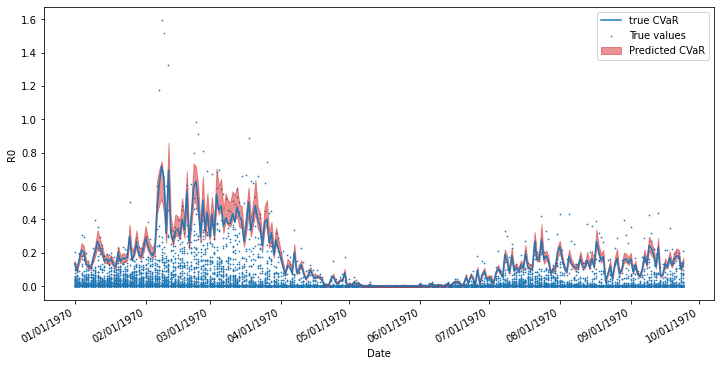

In [18]:
plot_cvar(df_test_blstm, figname='figures/blstm_2021_CVaR.pdf');